**Задание 2**

    Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10
    Библиотеки: [Python, Tensorflow]



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [2]:
#Загружаем данные
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train shape:', x_train.shape)

170508288/170498071 [==============================] - 13s 0us/step
x_train shape: (50000, 32, 32, 3)


In [4]:
#Преобразуем данные
x_train = x_train.reshape(-1, 32, 32, 3).astype('float32') / 255.
x_test = x_test.reshape(-1, 32, 32, 3).astype('float32') / 255.
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [5]:
#Объединим в единный вектор
y_train = y_train.flatten()
y_test = y_test.flatten()

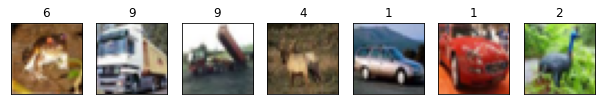

In [7]:
#Посмотрим сэмплы из датасета
samples = x_train[:7, ...]

fig = plt.figure(figsize=(12, 7))
for i in range(samples.shape[0]):
  ax = fig.add_subplot(4, 8, i+1)
  ax.imshow(samples[i, :, :, :], cmap='gray')
  plt.title(y_train[i])
  plt.xticks([]), plt.yticks([])
plt.show()

In [8]:
#Создаем пайплайн
NUM_EPOCHS = 10
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(buffer_size=x_train.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [9]:
#Создаем модель - CNN
class Model(tf.keras.Model):

  def __init__ (self):
    super(Model, self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')
    self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu')
    self.conv3 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')
    # self.conv4 = tf.keras.layers.Conv2D(256, (2, 2), padding='same', activation='relu')
    self.maxpool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
    self.fs1 = tf.keras.layers.Dense(256, activation='relu')
    self.fs2 = tf.keras.layers.Dense(10, activation=None)
    self.flatten = tf.keras.layers.Flatten()

  def call(self, inp):

    out = self.conv1(inp)
    out = self.maxpool(out)
    out = self.conv2(out)
    out = self.maxpool(out)
    out = self.conv3(out)
    out = self.maxpool(out)
    # out = self.conv4(out)
    out = self.flatten(out)
    out = self.fs1(out)
    out = self.fs2(out)

    return out

model = Model()

In [10]:
#Для оценки точности создаем функцию точности и функцию потерь
def loss(logits, labels):
  return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
      logits=logits, labels=labels
  ))


def accuracy(logits, labels):
  predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
  return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

In [11]:
LEARNING_RATE = 0.001

optimazer = tf.keras.optimizers.Adam(LEARNING_RATE)
writer = tf.summary.create_file_writer('logs/adam')

In [12]:
#Запускаем обучение модели
%%time

for iteration, (images, labels) in enumerate(train_ds):

  with tf.GradientTape() as tape:
    logits = model(images)
    loss_value = loss(logits, labels)


  grads = tape.gradient(loss_value, model.trainable_variables)
  optimazer.apply_gradients(zip(grads, model.trainable_variables))


  if iteration % 200 == 0:
    test_logits = model(x_test[:256, ...])
    accuracy_value = accuracy(test_logits, y_test[:256, ...])

    print(f'{iteration}  Accuracy: {accuracy_value.numpy()*100:.2f}')

    with writer.as_default():
      tf.summary.scalar('accuracy', accuracy_value, iteration)
      tf.summary.scalar('loss', loss_value, iteration)

0  Accuracy: 11.72
200  Accuracy: 44.92
400  Accuracy: 50.78
600  Accuracy: 54.30
800  Accuracy: 60.16
1000  Accuracy: 60.94
1200  Accuracy: 62.89
1400  Accuracy: 65.23
1600  Accuracy: 60.55
1800  Accuracy: 65.62
2000  Accuracy: 65.23
2200  Accuracy: 67.58
2400  Accuracy: 69.14
2600  Accuracy: 70.70
2800  Accuracy: 68.36
3000  Accuracy: 69.92
3200  Accuracy: 69.92
3400  Accuracy: 67.97
3600  Accuracy: 72.66
3800  Accuracy: 71.09
4000  Accuracy: 71.88
4200  Accuracy: 69.14
4400  Accuracy: 69.53
4600  Accuracy: 75.00
4800  Accuracy: 73.83
5000  Accuracy: 72.66
5200  Accuracy: 70.31
5400  Accuracy: 71.88
5600  Accuracy: 74.22
5800  Accuracy: 69.14
6000  Accuracy: 72.66
6200  Accuracy: 73.44
6400  Accuracy: 76.95
6600  Accuracy: 72.27
6800  Accuracy: 70.31
7000  Accuracy: 73.05
7200  Accuracy: 71.88
7400  Accuracy: 72.27
7600  Accuracy: 69.53
7800  Accuracy: 73.44
CPU times: user 1min 42s, sys: 2.03 s, total: 1min 44s
Wall time: 1min 59s


In [14]:
%%time

test_logits = model(x_test)
accuracy_value = accuracy(test_logits, y_test).numpy()
print(f'Final accuracy:  {accuracy_value*100:.2f}')

Final accuracy:  73.07
CPU times: user 2.02 s, sys: 146 ms, total: 2.17 s
Wall time: 2.16 s


In [16]:
#Функция предсказания
def test_item(sample):

  logits = model(sample[None, ...])[0] 
  prediction = tf.nn.softmax(logits)
  ans = np.argmax(prediction)

  fig = plt.figure(figsize=(12, 4))
  ax = fig.add_subplot(1,2,1)
  ax.imshow(sample[:, :, 0], cmap='gray')
  plt.xticks([]), plt.yticks([])

  ax = fig.add_subplot(1, 2, 2)
  bar_list = ax.bar(np.arange(10), prediction, align='center')
  bar_list[ans].set_color('g')
  ax.set_xticks(np.arange(10))
  ax.set_xlim([-1, 10])
  ax.grid(True)
  plt.show()
  
  print(f'predicted: {ans}')

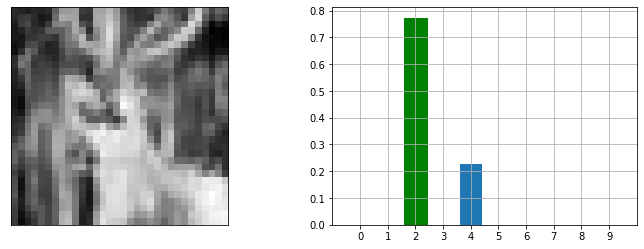

predicted: 2
True Answer: 4


In [17]:
# Сделаем предсказание на случайном объекте
import random

idx = random.randint(0, x_test.shape[0])
sample = x_test[idx, ...]
test_item(sample)

print(f'True Answer: {y_test[idx]}')

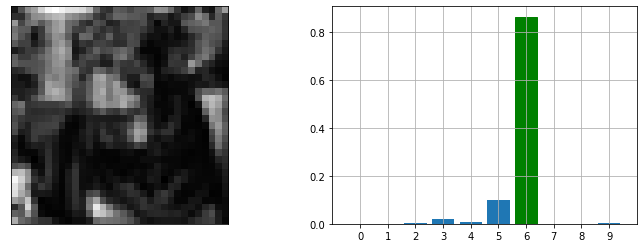

predicted: 6
True Answer: 5


In [18]:
idx = random.randint(0, x_test.shape[0])
sample = x_test[idx, ...]
test_item(sample)

print(f'True Answer: {y_test[idx]}')

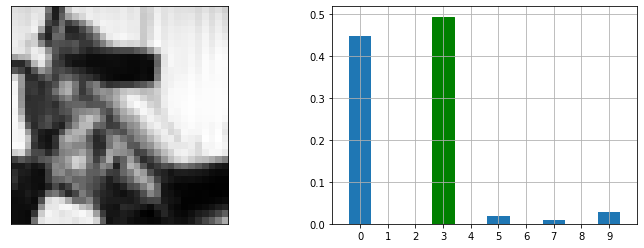

predicted: 3
True Answer: 0


In [19]:
idx = random.randint(0, x_test.shape[0])
sample = x_test[idx, ...]
test_item(sample)

print(f'True Answer: {y_test[idx]}')

Модель в 3-ех случаях дала верные предсказания, из чего делаем вывод, что она обучилась достаточно хорошо.